According to a [Stack Overflow Post](https://stackoverflow.com/a/34350553) it is possible ot use an AutoEncoder to compress the output of Word2Vec or RNNs down to smaller dimensions. Conversely, it is not realy feasible to try and implement a generative network directly using a Variational AutoEncoder (VAE).

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split

# pip install spacy-universal-sentence-encoder
import spacy_universal_sentence_encoder
nlp = spacy_universal_sentence_encoder.load_model('en_use_lg')

from functools import reduce
from tqdm import tqdm
import gensim
import gensim.corpora as corpora

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from Preprocessing import Preprocessor
preprocessor = Preprocessor(0)
tqdm.pandas()

In [77]:
limit = 2000

In [78]:
df = pd.read_csv("khan_joined.csv")
df.head()

,course,unit,lesson,video_title,about,transcript,transcript_cleaned,transcript_n_entries
0,Computer programming,Intro to JS: Drawing & Animation,Intro to programming,What is Programming?,Programming is the process of creating a set o...,"Hi, welcome to programming! If you've never le...","['help', 'computer', 'doodle', 'great', 'anima...",94
1,Computer programming,Intro to JS: Drawing & Animation,Coloring,The Power of the Docs,Created by Pamela Fox.,Voiceover: Ok so you've\r\nmade a few programs...,"['computer', 'refer', 'great', 'rect', 'like',...",161
2,Computer programming,Intro to HTML/CSS: Making webpages,Further learning,HTML validation,Learn how to validate your webpages with the W...,"- [Voiceover] On Khan Academy, we pop up the o...","['computer', 'try', 'validation', 'image', 'ac...",67
3,Computer programming,Intro to SQL: Querying and managing data,SQL basics,Welcome to SQL,SQL is useful for creating and querying relati...,- [Instructor] The world is full of data. Ever...,"['money', 'help', 'america', 'like', 'location...",79
4,Computer programming,Intro to SQL: Querying and managing data,SQL basics,S-Q-L or SEQUEL?,How is it pronounced? Why? Let's discuss...,"At this point, you've probably heard me\r\npro...","['probably', 'favorite', 'version', 'stand', '...",61


In [79]:
targets = df['course'][0:limit]
data = df['transcript_cleaned'][0:limit]

## Translate words to numerics
### Preliminary Research
[Link to article about Word2Vec and GloVe](https://forecast.global/insight/numerical-interpretation-of-textual-data-understanding-vector-representations/). More on encodings from [medium](https://medium.com/@kashyapkathrani/all-about-embeddings-829c8ff0bf5b).  


Word Embeddings are a possible option. BOW method would give a fixed length vector. Word2Vec also works for this, though it assumes a skip-gram model. GloVe uses a Continuous Bag of Words (CBOW) to do this instead. Does not work with words not seen during training. FastText extension should be able to as it breaks words into tri-grams.

Sentence embeddings better preserve context when compared to word embeddings. ELMo, InferSent, and Sentence-BERT all work in this case.

Can test sentence embeddings using SentEval tool-kit.

### Ideas
Try both Word embeddings and one of the sentence embeddings later. Using Word2Vec over Glove as we want to train our own Corpus.

### Word Embeddings

In [80]:
# def str_to_list(s: str) -> list:
#     s = s.replace('[', '')
#     s = s.replace(']', '')
#     s = s.replace('\'', '')
#     s = s.split(', ')
#     return s

# corpus = data.sum(axis=0)
# if isinstance(corpus, str):
#     # means it performed string concatenation so it needs to be cleaned up
#     print(corpus[0:100])
#     corpus = str_to_list(corpus)
#     print(corpus[0: 25])
#     print(len(corpus))
#     print(type(corpus))
# # convert the corpus to a set since there should be no unique values
# corpus = set(corpus)
# print(len(corpus))
# corpus = list(corpus)
# print(corpus[0:25])

# temp = [d.split() for d in corpus]
# print(type(temp))
# words = corpora.Dictionary(temp)
# words.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# corpus = [words.doc2bow(doc) for doc in temp]

### Sentence Embeddings
Ended up stumbling across a [SpaCy package]((https://spacy.io/universe/project/spacy-universal-sentence-encoder)) that used google's Universal Sentence Encoder model. This takes text and translates into a [512 dimensional vector](https://amitness.com/2020/06/universal-sentence-encoder/).

In [81]:
d1 = nlp(data[0])
d2 = nlp(data[1])
d1.similarity(d2)

0.5215909665018893

We have now verified that the sentence embedder works. Now we need to create a list of all sentences for each target domain.

In [82]:
joined = df[['course', 'transcript']][0:limit]
joined.head()

,course,transcript
0,Computer programming,"Hi, welcome to programming! If you've never le..."
1,Computer programming,Voiceover: Ok so you've\r\nmade a few programs...
2,Computer programming,"- [Voiceover] On Khan Academy, we pop up the o..."
3,Computer programming,- [Instructor] The world is full of data. Ever...
4,Computer programming,"At this point, you've probably heard me\r\npro..."


first off is that we notice the transcript has unicode characters and lots of weird tags. This is usually cleaned in the preprocessing pipeline so lets call that with different arguments.

In [83]:
joined['full_transcript'] = joined['transcript'].progress_apply(lambda x: preprocessor.clean(x))
joined.head()

100%|██████████| 2000/2000 [03:16<00:00, 10.20it/s]


,course,transcript,full_transcript
0,Computer programming,"Hi, welcome to programming! If you've never le...","(hi, ,, welcome, programming, !, never, learne..."
1,Computer programming,Voiceover: Ok so you've\r\nmade a few programs...,"(voiceover, :, ok, made, programs, ,, might, w..."
2,Computer programming,"- [Voiceover] On Khan Academy, we pop up the o...","(-, khan, academy, ,, pop, oh, noes, guide, te..."
3,Computer programming,- [Instructor] The world is full of data. Ever...,"(-, world, full, data, ., every, app, use, ful..."
4,Computer programming,"At this point, you've probably heard me\r\npro...","(point, ,, probably, heard, pronounce, sql, tw..."


In [84]:
type(joined['full_transcript'][0])

spacy.tokens.doc.Doc

We now have the SpaCy doc for every transcript in our dataset. Next is to use this to break things out by sentences

In [85]:
joined['sents'] = joined['full_transcript'].progress_apply(lambda x: list(x.sents))
joined.head()

100%|██████████| 2000/2000 [00:00<00:00, 14566.36it/s]


,course,transcript,full_transcript,sents
0,Computer programming,"Hi, welcome to programming! If you've never le...","(hi, ,, welcome, programming, !, never, learne...","[(hi, ,, welcome, programming, !), (never, lea..."
1,Computer programming,Voiceover: Ok so you've\r\nmade a few programs...,"(voiceover, :, ok, made, programs, ,, might, w...","[(voiceover, :, ok, made, programs, ,, might, ..."
2,Computer programming,"- [Voiceover] On Khan Academy, we pop up the o...","(-, khan, academy, ,, pop, oh, noes, guide, te...","[(-, khan, academy, ,, pop, oh, noes, guide, t..."
3,Computer programming,- [Instructor] The world is full of data. Ever...,"(-, world, full, data, ., every, app, use, ful...","[(-, world, full, data, .), (every, app, use, ..."
4,Computer programming,"At this point, you've probably heard me\r\npro...","(point, ,, probably, heard, pronounce, sql, tw...","[(point, ,, probably, heard, pronounce, sql, t..."


In [86]:
type(joined['sents'][0])

list

In [87]:
keys = joined['course'].unique()
result = []
for key in tqdm(keys):
    temp_df = joined[joined['course']==key]['sents']
    output = []
    for sentences in temp_df:
        for sentence in sentences:
            result.append({"label": key, "sent": str(sentence)})
        # output += encoding
        # output = np.concatenate((output, encoding), axis=0, out=None) # DO NOT USE NUMPY >>> MAY BREAK ENCODINGS
    # result.append((key, output))
result = pd.DataFrame(result)
result.head()

100%|██████████| 13/13 [00:00<00:00, 15.05it/s]


,label,sent
0,Computer programming,"hi, welcome programming!"
1,Computer programming,"never learned program before, might wondering ..."
2,Computer programming,"well, write program, giving computer series co..."
3,Computer programming,"think computer obedient dog, listening every c..."
4,Computer programming,cool programming?


we now have the sentences for each doc. Next step is to encode each of them with the universal encoder

https://www.geeksforgeeks.org/word-embedding-using-universal-sentence-encoder-in-python/

In [88]:
# import necessary libraries
import tensorflow_hub as hub
  
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [89]:
labels = result['label']
sents = result['sent']
embeddings = embed(sents)
print(embeddings.shape)
print(embeddings[0].shape)

(134082, 512)
(512,)


we now have a label, a sentence, and an embedding for each sentence. We can now discard the sentences themselves and work just with the labels and embeddings.

In [90]:
y = labels
x = embeddings


pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)

# result = pd.DataFrame()
result['pca-one'] = pca_result[:,0]
result['pca-two'] = pca_result[:,1] 
result['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
result.head(1)

Explained variation per principal component: [0.02883211 0.02695983 0.02128513]


,label,sent,pca-one,pca-two,pca-three
0,Computer programming,"hi, welcome programming!",0.154364,-0.073069,-0.126494


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

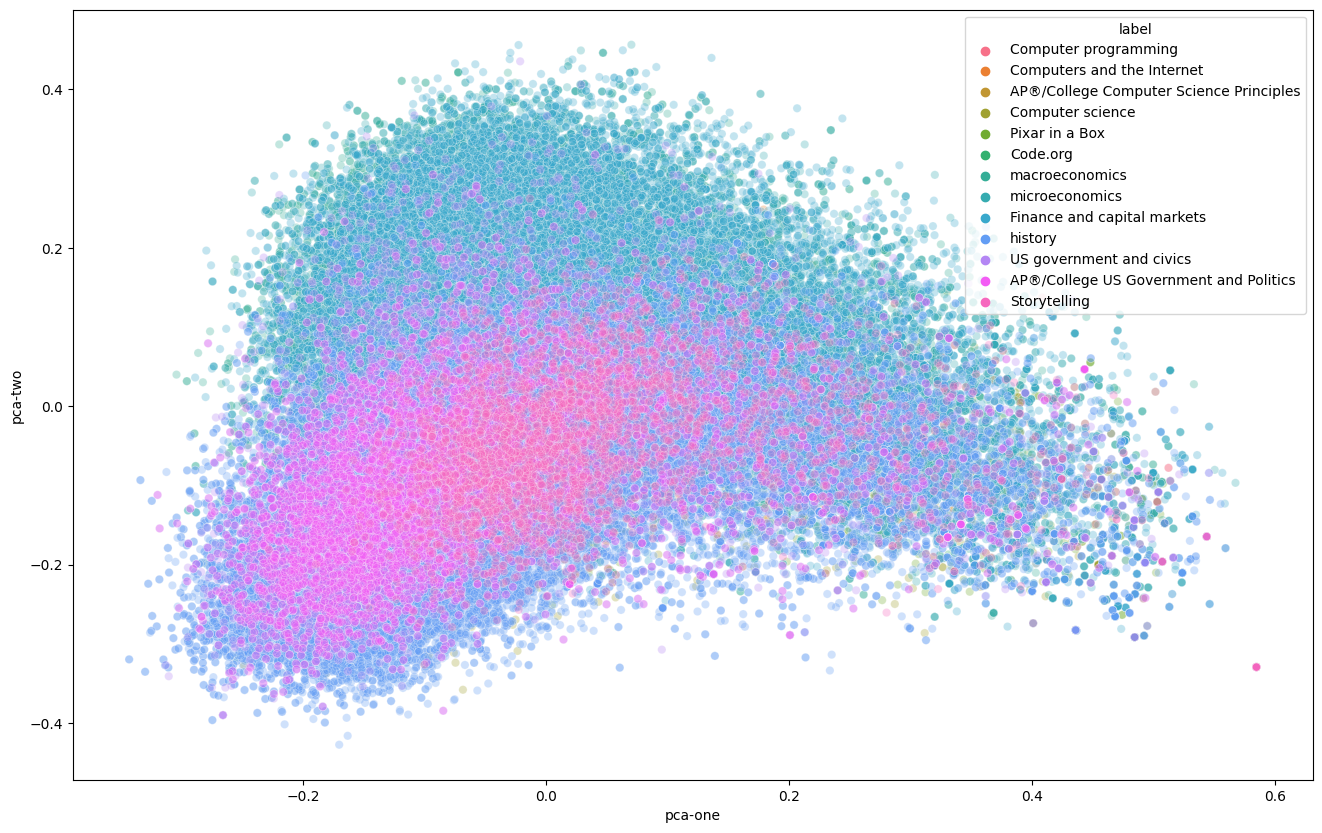

In [91]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=result["pca-one"], y=result["pca-two"],
    hue=result["label"],
    legend="full",
    alpha=0.3
)

In [92]:
unq = list(result['label'].unique())
lst = []
for element in result['label']:
    lst.append(unq.index(element))
result['y'] = lst

C:\Users\fassg\AppData\Local\Temp\ipykernel_53688\1110257658.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


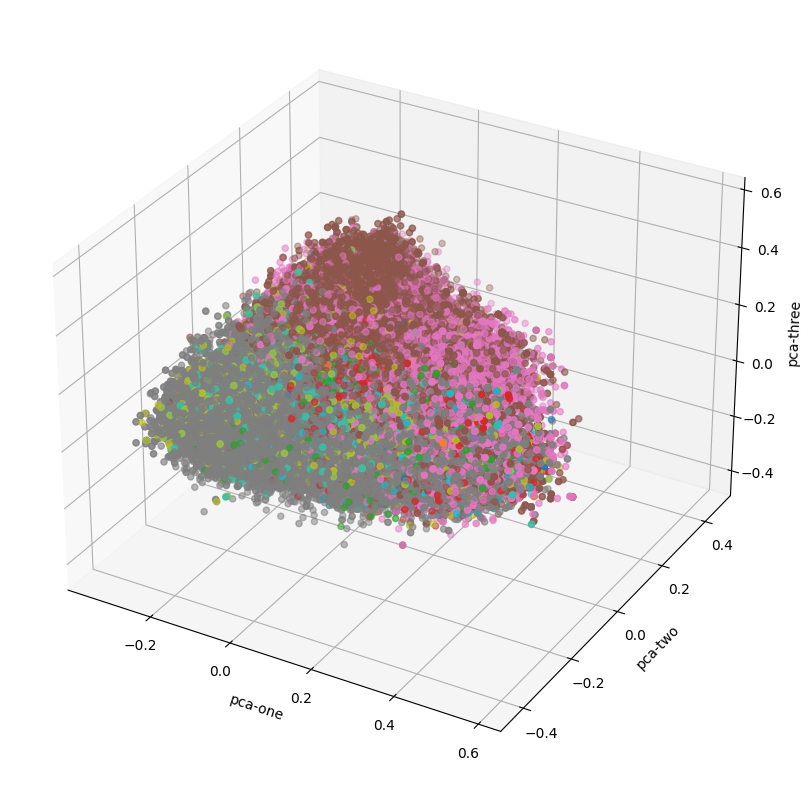

In [93]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    data=result,
    xs="pca-one", 
    ys="pca-two", 
    zs="pca-three", 
    c="y", 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## BELOW THIS POINT IS OLD COD

In [53]:
def to_str(lst: list) -> list:
    return list(map(str, lst))

def encode(lst: list) -> list:
    # return list(map(nlp, to_str(lst)))
    # return nlp(lst)
    print(lst)
    embed(lst)


print(type(result['sent'][0][0]))
# encode(joined['sents'][0])
# joined['encoding'] = joined['sents'].progress_apply(lambda x: encode(x))
# joined.head()
# result['encoding'] = result['sent'].progress_apply(lambda x: encode(x))
result['encoding'] = result['sent'].progress_apply(lambda x: encode(x))
result.head()

<class 'str'>


  0%|          | 1/5992 [00:00<00:30, 198.54it/s]

hi, welcome programming!


InvalidArgumentError: Graph execution error:

input must be a vector, got shape: []
	 [[{{node text_preprocessor/tokenize/StringSplit/StringSplit}}]] [Op:__inference_restored_function_body_80884]

In [48]:
type(result['encoding'][0])

list

In [49]:
type(result['encoding'][0][0])

spacy.tokens.doc.Doc

At this point we should now have a list of sentence embeddings for each document. next step is to group them by course. I found this [Stack Overflow Post](https://stackoverflow.com/questions/63796807/which-dimensionality-reduction-technique-works-well-for-bert-sentence-embeddings) on a simmilar problem. It recommends possibly using UMAP to perform dimensionality reduction.

want to put each encoding on their own row now to simulate individual nodes.

In [15]:
joined.groupby(by='course').count()

,transcript,full_transcript,sents,encoding
course,,,,
AP®︎/College Computer Science Principles,7,7,7,7
AP®︎/College US Government and Politics,87,87,87,87
Code.org,13,13,13,13
Computer programming,12,12,12,12
Computer science,48,48,48,48
Computers and the Internet,8,8,8,8
Finance and capital markets,317,317,317,317
Pixar in a Box,175,175,175,175
Storytelling,69,69,69,69


In [21]:
keys = joined['course'].unique()
result = []
for key in tqdm(keys):
    temp_df = joined[joined['course']==key]['encoding']
    output = []
    for encodings in temp_df:
        for encoding in encodings:
            result.append({"label": key, "encoding": encoding})
        # output += encoding
        # output = np.concatenate((output, encoding), axis=0, out=None) # DO NOT USE NUMPY >>> MAY BREAK ENCODINGS
    # result.append((key, output))
result = pd.DataFrame(result)
result.head()
        

100%|██████████| 13/13 [00:00<00:00, 20.47it/s]


,label,encoding
0,Computer programming,"(hi, ,, welcome, programming, !)"
1,Computer programming,"(never, learned, program, before, ,, might, wo..."
2,Computer programming,"(well, ,, write, program, ,, giving, computer,..."
3,Computer programming,"(think, computer, obedient, dog, ,, listening,..."
4,Computer programming,"(cool, programming, ?)"


In [22]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134082 entries, 0 to 134081
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   label     134082 non-null  object
 1   encoding  134082 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


Have all of the sentence encodings per each topic now. Can compare them with similarity() method. Now want to build graph somehow. To create an easily understandable graph we would need to go down to 2 or 3 dimensions. This can be done using t-sne according to two tutorials: [tutorial 1](https://towardsdatascience.com/visualizing-context-with-googles-universal-sentence-encoder-and-graphdb-c5f92b2f3db3) and [tutorial 2](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1). Downside is that t-sne scales quadratically so we basically cannot use it at over 134k records for just 200 of our original transcripts.

In [29]:
y = result['label']
x = result['encoding']

pca = PCA(n_components=3)
pca_result = pca.fit_transform(x.values)

result['pca-one'] = pca_result[:,0]
result['pca-two'] = pca_result[:,1] 
result['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# embed = TSNE().fit_transform(result['encoding'])

ValueError: setting an array element with a sequence.